# Exploitation des données enrichies à l'aide du SPARQL endpoint d'ISIDORE

L'utilisation d'ISIDORE et de son SPARQL *end point* permet d'analyser, par exemple, la répartition disciplinaire de données issues d'un corpus de document. Dans le cadre de cette séance, nous avons voir quelle est la répartition disciplinaire des données du programme de recherche AsilEuropeXIX (voir : https://asileurope.huma-num.fr) à l'aide des enrichissements sémantiques produit par ISIDORE.

## Comprendre les données : présentation scientifique du projet par l'équipe de recherche

Pour information, AsilEuropeXIX est un programme de recherche de l'Université de Reims-Champagne-Ardenne / Agence nationale de la recherche sur l’Europe du XIXe siècle.

L'équipe du projet présente le programme tel que : 

>L'Europe a vu l’institutionnalisation de l’exil comme forme de mobilisation et d’engagement politique, aussi bien parmi les membres de « l’internationale libérale » qui s’est constituée et s’est renforcée après le congrès de Vienne, que parmi ceux de « l’internationale blanche » contre-révolutionnaire. Afin de cerner au plus près cette mutation, ce programme de recherche « Jeunes chercheuses jeunes chercheurs », financé par l’Agence nationale de la recherche, se concentre sur les années 1830-1870, période décisive pour la définition progressive de l’exil et de l’asile politiques, mais aussi pour la mise au point des dispositifs d’accueil réservés aux victimes étrangères d’une répression.

## AsilEuropeXIX dans ISIDORE

Les documents du site AsilEurope sont disponibles dans ISIDORE depuis juin 2018. L'équipe du programme de recherche et son prestataire a encodé les métadonnées sous la forme d'informations structurées en RDF (technique décrite ici : https://documentation.huma-num.fr/content/12/77/fr/comment-signaler-ses-donnees-dans-isidore-avec-des-metadonnees-rdfa-.html). Ces métadonnées ont permis — avec l'utilisation de référentiels scientifiques et techniques, d'enrichir en informations les documents (voir : https://www.rechercheisidore.fr/referentiels). Les métadonnées et les enrichissements sont exportés en RDF et sont disponibles en libre accès dans une base de données RDF (aussi nommé *triple store*). Le triple store d'ISIDORE est disponible sur https://www.rechercheisidore.fr/sqe (accès documenté) et https://www.rechercheisidore.fr/sparql (interface Virtuoso).

## Objectif de la séance

Nous souhaitons exploiter et visualiser les enrichissements sémantiques crées autour de la source AsilEuropeXIX.

### Analyse de la répartition disciplinaire des doccuments disponibles pour AsilEuropeXIX (plus de 2000 à ce jour).

Pour ce travail, nous allons utiliser : 

- Une requête SPARQL
- Trois librairies Python : SPARQLWrapper, Pandas, Matplotlib

### La requête SPARQL

La requête :

    PREFIX sioc: <http://rdfs.org/sioc/ns#>
    PREFIX dcterms: <http://purl.org/dc/terms/>
    PREFIX foaf: <http://xmlns.com/foaf/0.1/>
    PREFIX ore: <http://www.openarchives.org/ore/terms/>
    PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
    SELECT ?label (count(?documents) as ?count) WHERE {
        <http://isidore.science/collection/10670/2.qfy8eq> ore:aggregates ?documents.
        ?documents sioc:topic ?topic.
        ?topic skos:prefLabel ?label.
        FILTER(lang(?label)="fr")
    }
    GROUP BY ?label
    ORDER BY DESC(?count) LIMIT 10

Cette requête analyse pour chaque document de la source ISIDORE "AsilEuropeXIX" : 

    <http://isidore.science/collection/10670/2.qfy8eq> ore:aggregates ?documents.
   
les "topic", c'est à dire les enrichissements réalisés à l'aide des disciplines de HAL (voir : https://rechercheisidore.fr/referentiels) et en sélectionne les labels :

    ?ressources sioc:topic ?topic.
    ?topic skos:prefLabel ?label.
    
les comptes :

    SELECT ?label (count(?ressources) as ?count) WHERE {
    
Les informations sont structurées avec les vocabulaires SIOC, DC Terms, SKOS : 

    PREFIX sioc: <http://rdfs.org/sioc/ns#>
    PREFIX dcterms: <http://www.openarchives.org/ore/terms/>
    PREFIX skos: <http://www.w3.org/2004/02/skos/core#>

### Réalisation

Nous utiliserons donc trois librairies :
- Le service SPARQLWrapper : pour interroger le SPARQL end point d'ISIDORE
- Pandas : pour traiter des informations en JSON que l'interface du SPARQL end point va nous renvoyer depuis le triple-store RDF
- Matplotlib : pour représenter les informations sous la forme d'un diagramme circulaire

Le programme commence par leur appel :

In [1]:
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd
import matplotlib.pyplot as plt

On définit l'adresse du SPARQL *end point* :

In [2]:
sparql = SPARQLWrapper("http://isidore.science/sparql")

On passe la requête SPARQL :

In [3]:
sparql.setQuery("""
PREFIX sioc: <http://rdfs.org/sioc/ns#>
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX ore: <http://www.openarchives.org/ore/terms/>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
SELECT ?label (count(?documents) as ?count) WHERE {
    <http://isidore.science/collection/10670/2.qfy8eq> ore:aggregates ?documents.
    ?documents sioc:topic ?topic.
    ?topic skos:prefLabel ?label.
    FILTER(lang(?label)="fr")
}
GROUP BY ?label
ORDER BY DESC(?count) LIMIT 10
""")

On demande à avoir les resultats en JSON (puis qu'ISIDORE le permet) et on lance la requête via le SPARQL *end-point* :

In [4]:
sparql.setReturnFormat(JSON)
results = sparql.query().convert()

On utilise la fonction *json_normalize* de Pandas pour capter les informations du JSON et créer une table à plat de données (ou sets de données, voir : https://pandas.pydata.org/pandas-docs/stable/generated/pandas.io.json.json_normalize.html :

In [6]:
results_df = pd.json_normalize(results['results']['bindings'])
labels = results_df['label.value']
data = results_df['count.value']

Ainsi :

- *data* contiendra les valeurs numériques
- *labels* les labels des disciplines

On crée ensuite, avec Matplotlib, un petit diagramme circulaire.

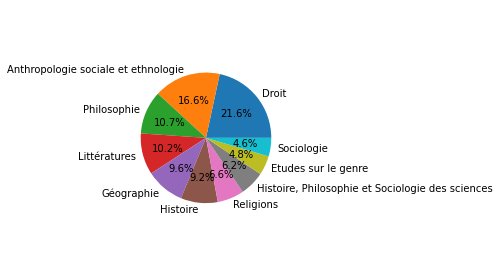

In [7]:
plt.pie(data,labels=labels,explode=None,autopct='%1.1f%%',shadow=False)
plt.axis('equal')
plt.tight_layout()
plt.show()

Code complet et résultat :

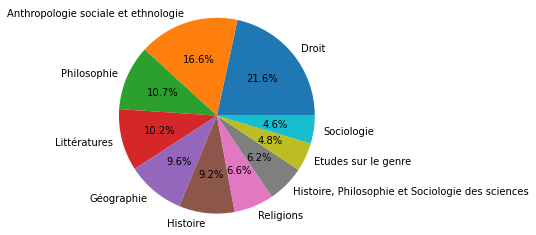

In [8]:
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd
import matplotlib.pyplot as plt

sparql = SPARQLWrapper("http://isidore.science/sparql")
sparql.setQuery("""
PREFIX sioc: <http://rdfs.org/sioc/ns#>
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX ore: <http://www.openarchives.org/ore/terms/>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
SELECT ?label (count(?documents) as ?count) WHERE {
    <http://isidore.science/collection/10670/2.qfy8eq> ore:aggregates ?documents.
    ?documents sioc:topic ?topic.
    ?topic skos:prefLabel ?label.
    FILTER(lang(?label)="fr")
}
GROUP BY ?label
ORDER BY DESC(?count) LIMIT 10

""")
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
results_df = pd.json_normalize(results['results']['bindings'])
labels = results_df['label.value']
data = results_df['count.value']
plt.pie(data,labels=labels,explode=None,autopct='%1.1f%%',shadow=False)
plt.axis('equal')
plt.show()
plt.close()